In [13]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
from PIL import Image

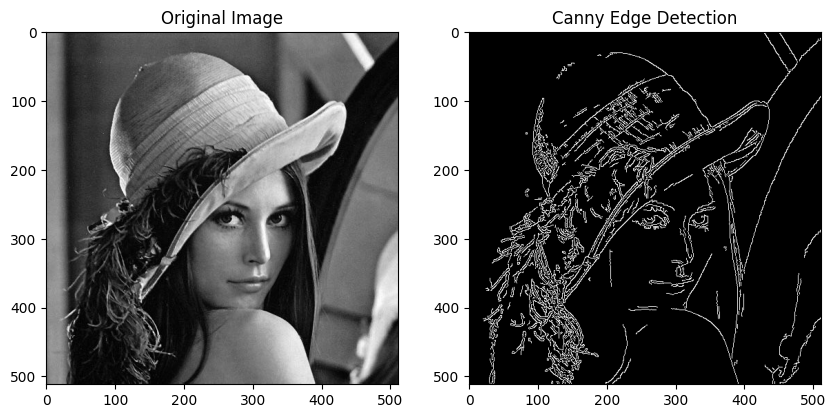

In [6]:
# Task 1.1: Edge-based segmentation using Canny
def edge_detection(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 100, 200)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1,2,2)
    plt.imshow(edges, cmap='gray')
    plt.title('Canny Edge Detection')
    plt.show()
edge_detection('image.jpg')

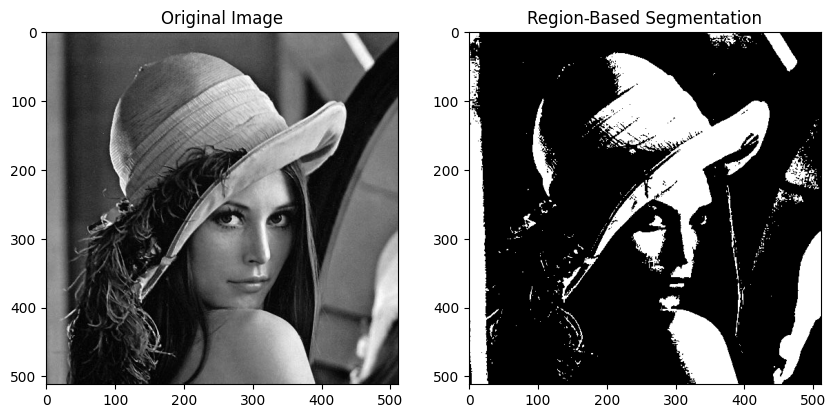

In [10]:
# Task 1.2: Region-Based Segmentation
def region_based_segmentation(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, binary_thresh = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.subplot(1,2,2)
    plt.imshow(binary_thresh, cmap='gray')
    plt.title('Region-Based Segmentation')
    plt.show()
region_based_segmentation('image.jpg')

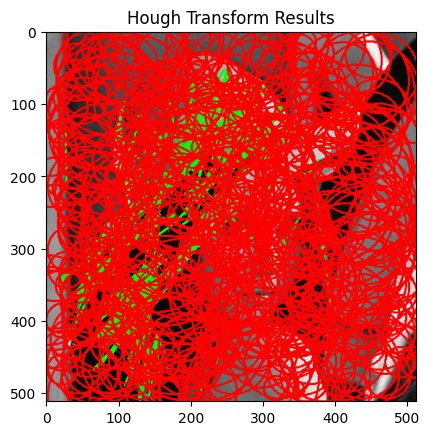

In [11]:
# Task 1.3: Hough Transform for detecting lines and circles
def hough_transform(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=50, maxLineGap=10)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=100)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(image, (i[0], i[1]), i[2], (0, 0, 255), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Hough Transform Results')
    plt.show()
hough_transform('image.jpg')

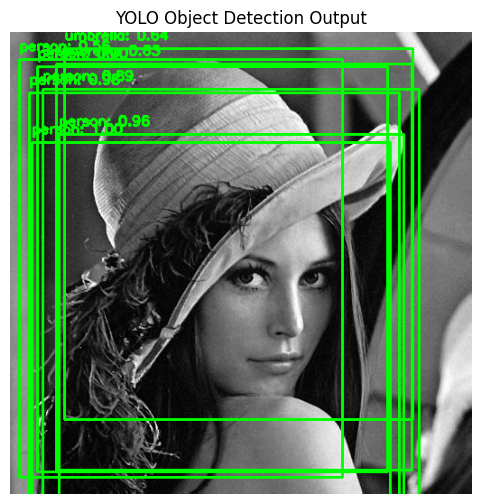

In [17]:
import os
import urllib.request
import cv2
import numpy as np
import matplotlib.pyplot as plt

def yolo_object_detection(image_path):
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

    with open("coco.names", "r") as f:
        class_names = [line.strip() for line in f.readlines()]

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found! Check the file path.")
        return

    height, width = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    detections = net.forward(output_layers)

    for output in detections:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype("int")
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                color = (0, 255, 0)
                cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
                label = f"{class_names[class_id]}: {confidence:.2f}"
                cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("YOLO Object Detection Output")
    plt.show()

yolo_object_detection('image.jpg')

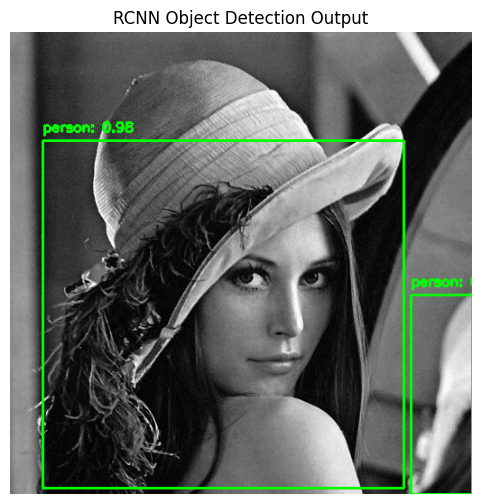

In [19]:
import torch
import torchvision.transforms as transforms
import torchvision.models.detection as models
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np

model = models.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

def rcnn_object_detection(image_path, confidence_threshold=0.5):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        predictions = model(image_tensor)

    image_cv = cv2.imread(image_path)
    image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    boxes = predictions[0]["boxes"].cpu().numpy()
    scores = predictions[0]["scores"].cpu().numpy()
    labels = predictions[0]["labels"].cpu().numpy()

    COCO_INSTANCE_CATEGORY_NAMES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
        'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
        'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe'
    ]

    for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
        if score > confidence_threshold:
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(image_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label_text = f"{COCO_INSTANCE_CATEGORY_NAMES[label]}: {score:.2f}"
            cv2.putText(image_cv, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(image_cv)
    plt.axis("off")
    plt.title("RCNN Object Detection Output")
    plt.show()
rcnn_object_detection('image.jpg')
